# Loading the data

In [12]:
import pandas as pd
from numpy import *

In [13]:
import h5py

In [14]:
Tlist = [194, 258, 320, 400]
mQs = [0.541, 0.48310124982957725, .4693567764702764, .4842280338723185]
Trange = array(Tlist)*1e-3
keylist = ['0.99Tc', '1.32Tc', '1.63Tc', '2.04Tc']

In [15]:
f = h5py.File('./194/TmLogDataEpc.h5')

In [16]:
erange_TM = arange(0, 9.01, 0.05)
qrange_TM = arange(0, 6.01, 0.05)

In [17]:
f.keys()

<KeysViewHDF5 ['0.99Tc']>

In [18]:
f['0.99Tc']['lightplightn']['Ca1'].keys()

<KeysViewHDF5 ['wave0', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5']>

In [19]:
qrange_TM[10]

0.5

(0.0, 4.0)

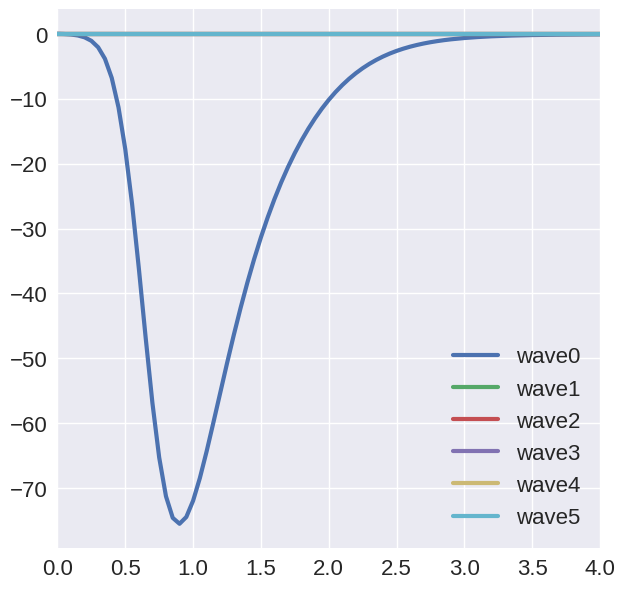

In [20]:
for k, w in f['0.99Tc']['lightplightn']['Ca1'].items():
    plt.plot(erange_TM, 4*pi/6*4*w[1, :, 0], label=k)

plt.legend()
plt.xlim(0, 4)

In [21]:
TMs = []

for T, key in zip(Tlist, keylist):
    f = h5py.File('./%s/TmLogDataEpc.h5'%T)
    vals = f[key]['lightplightn']['Ca1']['wave0']
    TMs += [vals[0, :, :] + 1j*vals[1, :, :]]

In [22]:
erange_SF = arange(-1, 5.01, 0.05)
qrange_SF = arange(0, 3.01, 0.05)

In [23]:
Sigmas = []

for T in Tlist:

    f_SE = h5py.File('./%s/SelfE.h5'%T)
    ds_SE = f_SE['lightp']

    ds_Im = ds_SE[1, :, :]

    df_Im = []

    for i in range(121):
        df_Im += [ds_Im[i::121]]

    df_Im = array(df_Im)

    df_Im_vals = zeros([121, 61])

    for i in range(121):
        for j in range(61):
            df_Im_vals[i, j] = df_Im[i, j, -1]

    ds_Re = ds_SE[0, :, :]

    df_Re = []

    for i in range(121):
        df_Re += [ds_Re[i::121]]

    df_Re = array(df_Re)

    df_Re_vals = zeros([121, 61])

    for i in range(121):
        for j in range(61):
            df_Re_vals[i, j] = df_Re[i, j, -1]
            
    Sigmas += [df_Re_vals + 1j * df_Im_vals]

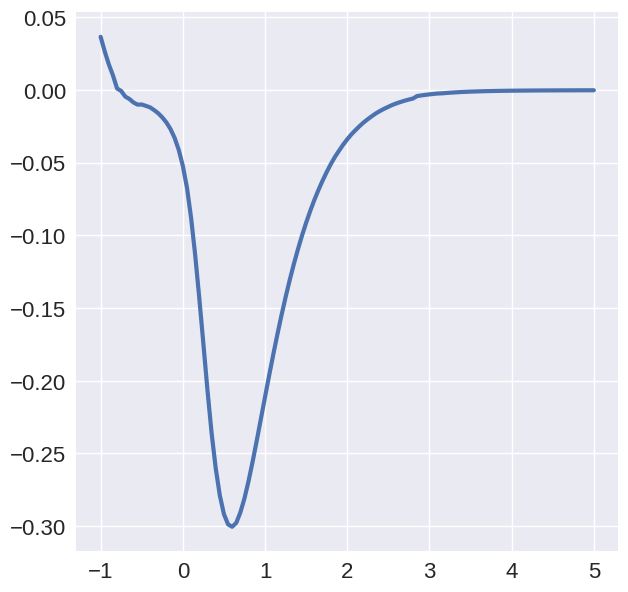

In [24]:
plt.plot(erange_SF, imag(Sigmas[0][:, 0]))

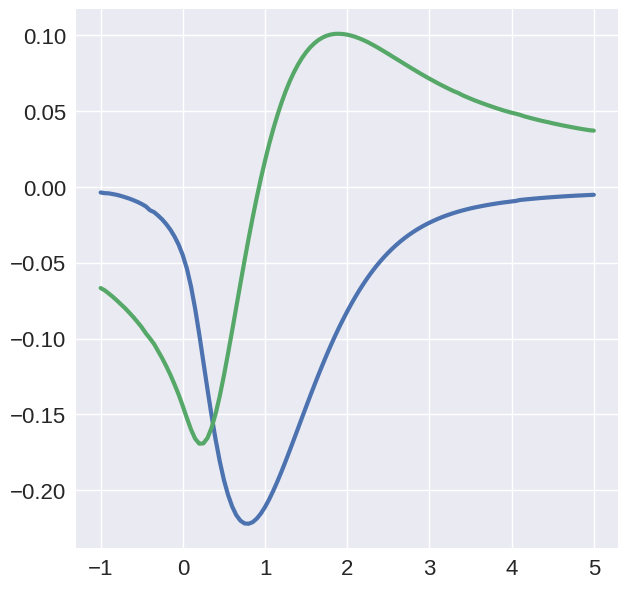

In [25]:
plt.plot(erange_SF, df_Im_vals[:, 0])
plt.plot(erange_SF, df_Re_vals[:, 0])

In [26]:
Gs = []

for mQ, Sigma in zip(mQs, Sigmas):
    arrE = array([erange_SF for q in qrange_SF]).transpose()
    arrOm = array([sqrt(mQ**2 + qrange_SF**2) for e in erange_SF])
    Gs += [1/(arrE - arrOm - Sigma)]

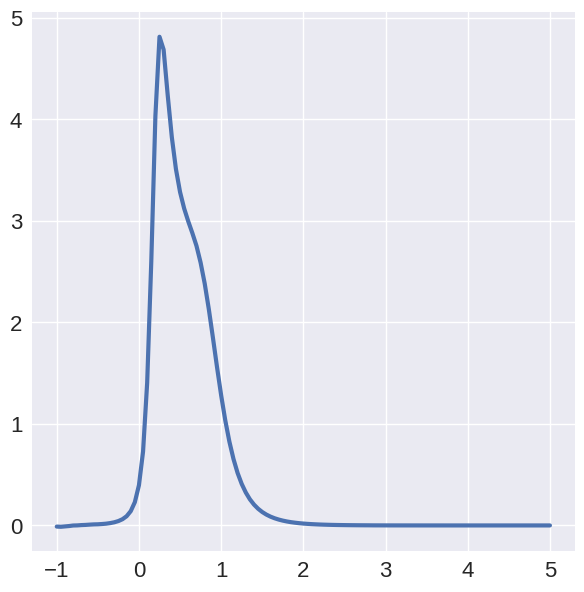

In [27]:
plt.plot(erange_SF, -imag(Gs[0][:, 0]))

In [28]:
trapz(-imag(Gs[0][:, 0])/pi, x=erange_SF)

1.000114668293734

# Calculating the thermodynamics

## QP contribution

In [29]:
import TMQGP as tm
import QuarkTM

In [30]:
P_Q = []

for T, Tval, G, mQ in zip(Tlist, Trange, Gs, mQs):
    q = QuarkTM.Particle(mQ, qrange_SF, erange_SF, Gtab=G)
#     plt.plot(erange_SF, [tm.delta(e, 0, q.iImG, q.iReG) for e in erange_SF])
#     plt.plot(qrange_SF, [tm.OmQ_F_om_int(_, Tval, q.iImG, q.iReG) for _ in qrange_SF])
    p_Q = tm.OmQ_F(Tval, q.iImG, q.iReG)
    P_Q += [p_Q]

P_Q = array(P_Q)

(-1.5, 2.2)

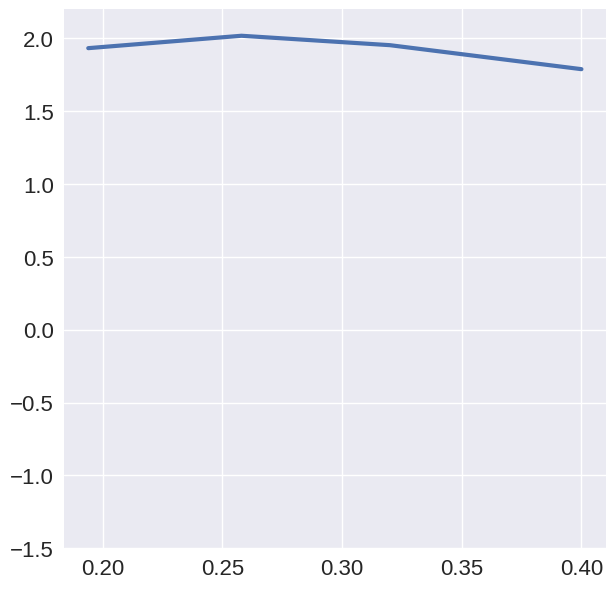

In [31]:
plt.plot(Trange, 3*3*2*P_Q/Trange**4)

plt.ylim(-1.5, 2.2)

## Self-energy contribution

In [32]:
P_S = []

for T, Tval, G, mQ, Sigma in zip(Tlist, Trange, Gs, mQs, Sigmas):
    q = QuarkTM.Particle(mQ, qrange_SF, erange_SF, Gtab=G)
#     plt.plot(erange_SF, [tm.delta(e, 0, q.iImG, q.iReG) for e in erange_SF])
#     plt.plot(qrange_SF, [tm.OmQ_F_om_int(_, Tval, q.iImG, q.iReG) for _ in qrange_SF])
    iImS = tm.Interpolator2D(qrange_SF, erange_SF, ascontiguousarray(imag(Sigma)))
    iReS = tm.Interpolator2D(qrange_SF, erange_SF, ascontiguousarray(real(Sigma)))
    p_S = tm.OmS_F(Tval, q.iImG, q.iReG, iImS, iReS)
    P_S += [p_S]

P_S = array(P_S)

In [33]:
from scipy.integrate import quad

In [34]:
Pfree = array([quad(lambda z: z*z*T*log(1 + exp(-sqrt(m**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] 
               for T, m in zip(Trange, mQs)])

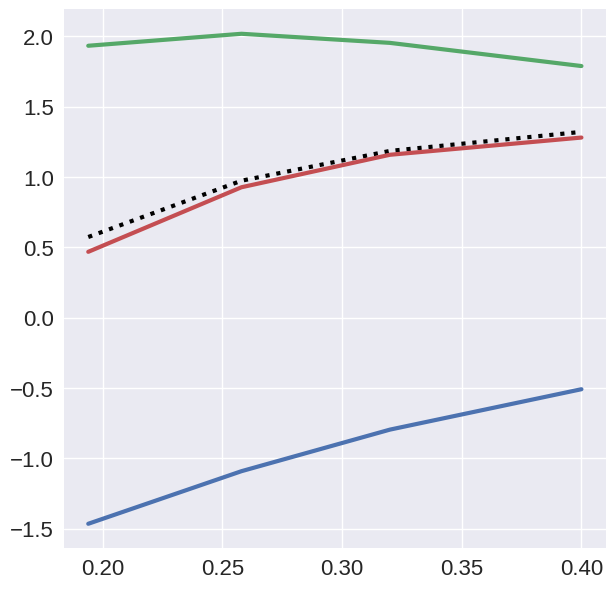

In [35]:
plt.plot(Trange, -3*3*2*P_S/Trange**4)
plt.plot(Trange, 3*3*2*P_Q/Trange**4)
plt.plot(Trange, 3*3*2*Pfree/Trange**4, c='black', ls=':')

plt.plot(Trange, 3*3*2*(P_Q - P_S)/Trange**4)

## $\Phi$ contribution

In [36]:
from tqdm import notebook as tqdm
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

In [37]:
LSs = []

for T, Tval, G, mQ, Sigma, LT in zip(Tlist, Trange, Gs, mQs, Sigmas, TMs):
    q = QuarkTM.Particle(mQ, qrange_SF, erange_SF, Gtab=G)
    
    iImLT = tm.Interpolator2D(qrange_TM, erange_TM, ascontiguousarray(imag(
        4*pi*3*4*1 / 6 * LT
    )))
    
    iEps = tm.Interpolator(q.qrange, q.om0(q.qrange), 'linear')
    #pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
    ST = array([
        pipe(erange_SF) | p[lambda z: tm.sigma_ff_onshell(z, _, Tval, iImLT, q.R, iEps, iEps)] * NTHR | END
                for _ in tqdm.tqdm(qrange_SF)])

    ST = ST.transpose()

    iImST = tm.Interpolator2D(qrange_SF, erange_SF, ascontiguousarray(ST))

    ReST = []

    for res in tqdm.tqdm(ST.transpose()):
        iImSigma = tm.Interpolator(erange_SF, np.ascontiguousarray(res), 'cubic')
        ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange_SF]
        ReST += [ReSigma]

    ReST = np.array(ReST).transpose()
    
    LSs += [(ReST + 1j*ST)]
    

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

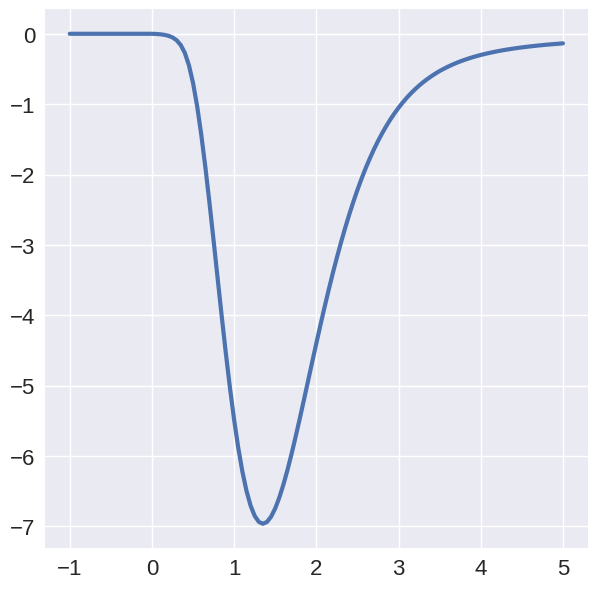

In [38]:
plt.plot(erange_SF, [iImLT(0, x) for x in erange_SF])

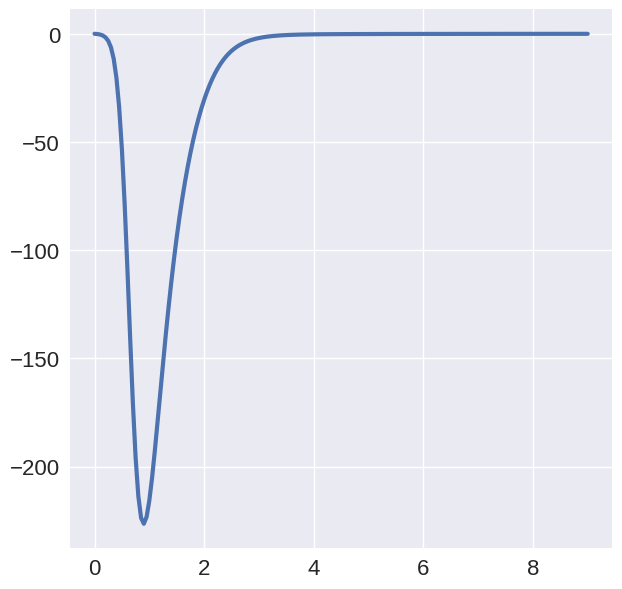

In [40]:
plt.plot(erange_TM, 4*pi*3/6*4*imag(TMs[0])[:, 0])

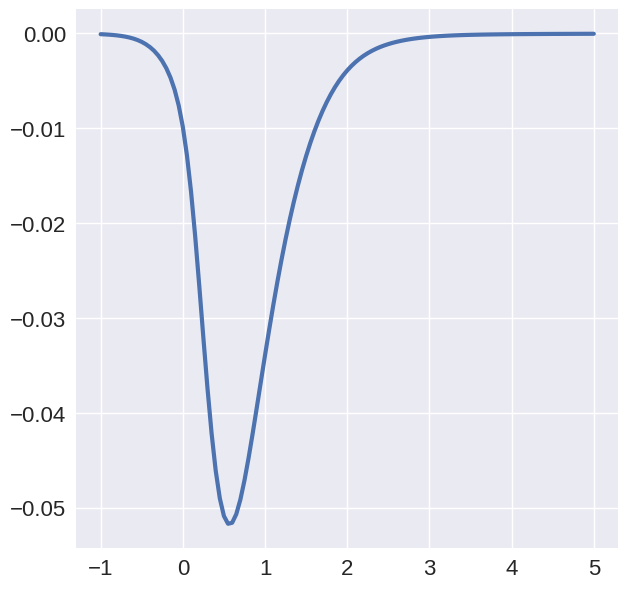

In [43]:
plt.plot(erange_SF, imag(LSs[0])[:, 0])

In [44]:
P_Phi = []

for T, Tval, G, mQ, LS in zip(Tlist, Trange, Gs, mQs, LSs):
    q = QuarkTM.Particle(mQ, qrange_SF, erange_SF, Gtab=G)
#     plt.plot(erange_SF, [tm.delta(e, 0, q.iImG, q.iReG) for e in erange_SF])
#     plt.plot(qrange_SF, [tm.OmQ_F_om_int(_, Tval, q.iImG, q.iReG) for _ in qrange_SF])
    iImS = tm.Interpolator2D(qrange_SF, erange_SF, ascontiguousarray(imag(LS)))
    iReS = tm.Interpolator2D(qrange_SF, erange_SF, ascontiguousarray(real(LS)))
    p_Phi = tm.OmS_F(Tval, q.iImG, q.iReG, iImS, iReS)
    P_Phi += [p_Phi]

P_Phi = array(P_Phi)

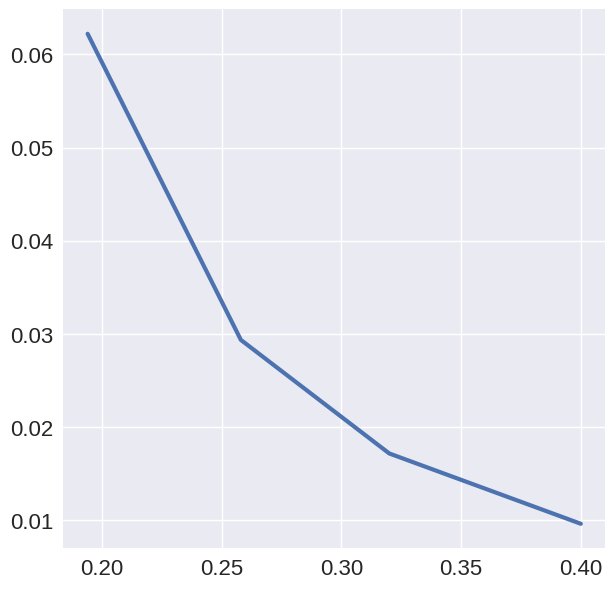

In [48]:
plt.plot(Trange, 3*3*2*P_Phi/Trange**4 / 2)

In [50]:
P_Phi[0]

9.791488998587384e-06

Text(0, 0.5, '$P/T^4$')

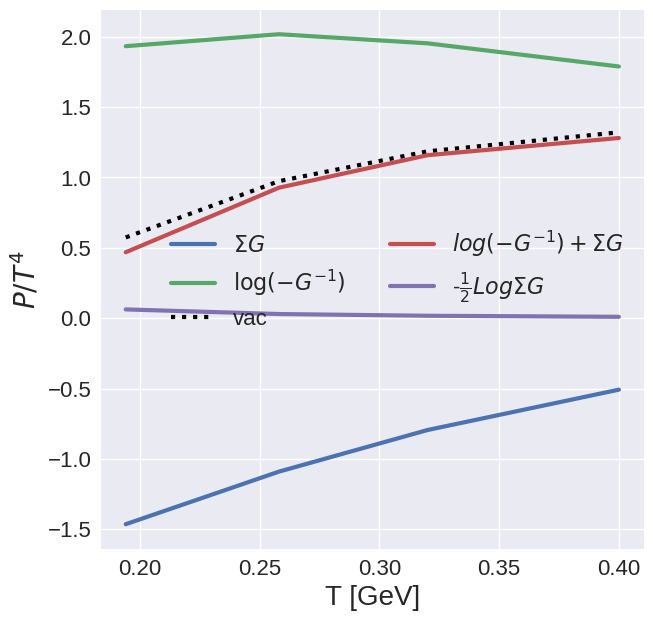

In [49]:
plt.plot(Trange, -3*3*2*P_S/Trange**4, label=r'$\Sigma G$')
plt.plot(Trange, 3*3*2*P_Q/Trange**4, label=r'$\log(-G^{-1})$')
plt.plot(Trange, 3*3*2*Pfree/Trange**4, c='black', ls=':', label='vac')

plt.plot(Trange, 3*3*2*(P_Q - P_S)/Trange**4, label='$log(-G^{-1}) + \Sigma G$')

plt.plot(Trange, 3*3*2*P_Phi/Trange**4/2, label=r'-$\frac{1}{2} Log\Sigma G$')

plt.legend(ncol=2, loc='center right')

plt.xlabel('T [GeV]')
plt.ylabel('$P/T^4$')